<a href="https://colab.research.google.com/github/yanlong-sun/DACN_BDC_LSTM/blob/master/final_conv_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

The
[Convolutional LSTM](https://papers.nips.cc/paper/2015/file/07563a3fe3bbe7e3ba84431ad9d055af-Paper.pdf)
architectures bring together time series processing and computer vision by
introducing a convolutional recurrent cell in a LSTM layer. In this example, we will explore the
Convolutional LSTM model in an application to next-frame prediction, the process
of predicting what video frames come next given a series of past frames.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd drive/My\ Drive/test/

/content/drive/My Drive/test


## Setup

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

## Dataset Construction

For next-frame prediction, our model will be using a previous frame,
which we'll call `f_n`, to predict a new frame, called `f_(n + 1)`.
To allow the model to create these predictions, we'll need to process
the data such that we have "shifted" inputs and outputs, where the
input data is frame `x_n`, being used to predict frame `y_(n + 1)`.

In [ ]:
import os
path = r'../project/Dataset/training_data/training_data_bmp/masks_npy_in10/'
npy_list = sorted(os.listdir(path))
npy_nums = len(npy_list)
print(npy_nums)
choosen_idx = np.arange(npy_nums)
np.random.shuffle(choosen_idx)
print(choosen_idx)
training_data = np.empty([1000, 5, 256, 256, 1], dtype=np.uint8)
valid_data = np.empty([100, 5, 256, 256, 1], dtype=np.uint8)
for count, i in enumerate(choosen_idx):
    npy_name = path + npy_list[i]
    loaded_npy = np.load(npy_name)
    loaded_npy = loaded_npy[0:5, :, :]
    loaded_npy = np.expand_dims(loaded_npy, axis=-1)
    if count < 1000:
        training_data[count, :, :, :, :] = loaded_npy
        continue
    elif 1000 <= count < 1100:
        valid_data[count-1000, :, :, :, :] = loaded_npy
        continue
    break
np.save("training_data.npy", training_data)
np.save("valid_data.npy", valid_data)

In [15]:
#training_data = np.load("training_data.npy")
valid_data = np.load("valid_data.npy")

In [9]:
def create_shifted_frames(data):
    x = data[:, 0:data.shape[1] - 1, :, :]/255
    y = data[:, 1:data.shape[1], :, :]/255
    return x, y

x_train, y_train = create_shifted_frames(training_data)
x_valid, y_valid = create_shifted_frames(valid_data)
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_valid.shape) + ", " + str(y_valid.shape))
np.save("x_train.npy", x_train)
np.save("y_train.npy", y_train)
np.save("x_valid.npy", x_valid)
np.save("y_valid.npy", y_valid)

Training Dataset Shapes: (1000, 4, 256, 256, 1), (1000, 4, 256, 256, 1)
Validation Dataset Shapes: (100, 4, 256, 256, 1), (100, 4, 256, 256, 1)


## Data Visualization

Our data consists of sequences of frames, each of which
are used to predict the upcoming frame. Let's take a look
at some of these sequential frames.

Displaying frames for example 376.


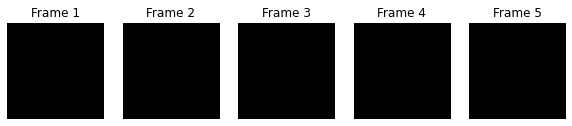

In [13]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(1, 5 , figsize=(10, 8))
# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(training_data)), size=1)[0]
for idx, ax in enumerate(axes.flat):
    img = tf.squeeze(training_data[data_choice][idx])
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {data_choice}.")
plt.show()

## Model Construction

To build a Convolutional LSTM model, we will use the
`ConvLSTM2D` layer, which will accept inputs of shape
`(batch_size, num_frames, width, height, channels)`, and return
a prediction movie of the same shape.

In [ ]:
x_train, y_train = np.load("x_train.npy"), np.load("y_train.npy")
x_valid, y_valid = np.load("x_valid.npy"), np.load("y_valid.npy")

In [11]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None, 256, 256, 1 0         
_________________________________________________________________
conv_lst_m2d_15 (ConvLSTM2D) (None, None, 256, 256, 64 416256    
_________________________________________________________________
batch_normalization_10 (Batc (None, None, 256, 256, 64 256       
_________________________________________________________________
conv_lst_m2d_16 (ConvLSTM2D) (None, None, 256, 256, 64 295168    
_________________________________________________________________
batch_normalization_11 (Batc (None, None, 256, 256, 64 256       
_________________________________________________________________
conv_lst_m2d_17 (ConvLSTM2D) (None, None, 256, 256, 64 33024     
_________________________________________________________________
conv3d_5 (Conv3D)            (None, None, 256, 256, 1) 1729

## Model Training

With our model and data constructed, we can now train the model.

In [12]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_valid, y_valid),
    callbacks=[early_stopping, reduce_lr],
)
model.save("my_model")

Epoch 1/20
200/200 [==============================] - 293s 1s/step - loss: 0.0323 - val_loss: 0.2169
Epoch 2/20
200/200 [==============================] - 283s 1s/step - loss: 0.0025 - val_loss: 0.0899
Epoch 3/20
200/200 [==============================] - 283s 1s/step - loss: 0.0020 - val_loss: 0.0063
Epoch 4/20
200/200 [==============================] - 283s 1s/step - loss: 0.0016 - val_loss: 0.0016
Epoch 5/20
200/200 [==============================] - 283s 1s/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/20
200/200 [==============================] - 283s 1s/step - loss: 0.0012 - val_loss: 0.0012
Epoch 7/20
200/200 [==============================] - 283s 1s/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/20
200/200 [==============================] - 283s 1s/step - loss: 0.0012 - val_loss: 0.0013
Epoch 9/20
200/200 [==============================] - 283s 1s/step - loss: 0.0012 - val_loss: 0.0012
Epoch 10/20
200/200 [==============================] - 283s 1s/step - loss: 0.0012 - val_lo

In [ ]:
def get_train_batch(x_train, y_train, batch_size):
    while 1:
        for i in range(0, len(x_train), batch_size):
            x = x_train[i:i+batch_size]
            y = y_train[i:i+batch_size]
            yield({'input_1': x}, {'conv3d': y})


# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 20
batch_size = 4
# Fit the model to the training data.
gen = get_train_batch(x_train, y_train, batch_size)
model.fit(
    gen,
    epochs=epochs,
    validation_data=get_train_batch(x_valid, y_valid, batch_size),
    callbacks=[early_stopping, reduce_lr]
)
model.save("my_model")

## Frame Prediction Visualizations

With our model now constructed and trained, we can generate
some example frame predictions based on a new video.

We'll pick a random example from the validation set and
then choose the first ten frames from them. From there, we can
allow the model to predict 10 new frames, which we can compare
to the ground truth frame predictions.

(4, 256, 256, 1)
1.6794650059803372e-07


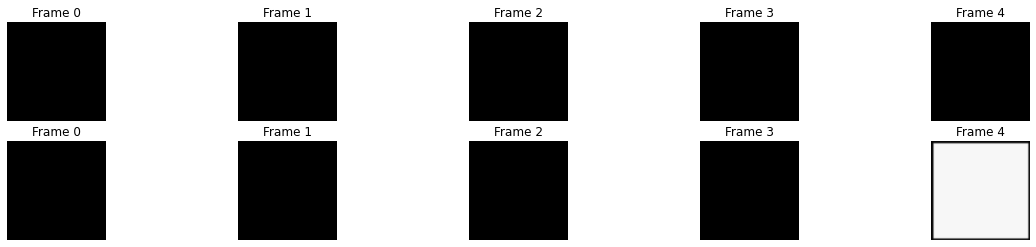

In [25]:
def dice_coeff(gt, out):
    intersection = np.sum(gt * out)
    dice = (2. * intersection + 0.000001) / (np.sum(gt) + np.sum(out) + 0.000001)
    if dice > 1:
        return -1
    return dice

# Select a random example from the validation dataset.
example = valid_data[np.random.choice(range(len(valid_data)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:4, ...]
original_frames = example[:5, ...]
print(frames.shape)
# model = keras.models.load_model("my_model")
# Predict next frame of the 'frames'
new_prediction = model.predict(np.expand_dims(frames, axis=0))
new_prediction = np.squeeze(new_prediction, axis=0)
predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
dice = dice_coeff(original_frames[4], new_prediction)
print(dice)
# Extend the set of prediction frames.
frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 5, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[:5  , ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx}")
    ax.axis("off")

# Display the figure.
plt.show()

## Predicted Videos

Finally, we'll pick a few examples from the validation set
and construct some GIFs with them to see the model's
predicted videos.

In [ ]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)